In [12]:
import numpy as np
from ueg import ueg_qc
from pyscf import gto, scf, ao2mo, cc
from ueg import my_ueg, ueg_qc

In [14]:
nocc = 7 # 7, 19, 27, 33, 57, 81, 93
system = ueg_qc(1.0, (nocc, nocc), e_cut_red=1.4)
# k_points = system.get_k_points()
my_sys = my_ueg(rs=1.0, nelec=(nocc, nocc))
k_points = my_sys.get_kpts(np.sqrt(2))
n_kpts = k_points.shape[0]
print(f"number of k-points: {n_kpts}")
h0 = system.madelung() / 2
h1 = system.get_h1_real(k_points)
eri = system.get_eri_tensor_real(k_points)
eri = np.array(eri)

mol = gto.M()
mol.nelectron = system.n_particles
mol.nao = n_kpts
mol.incore_anyway = True
mol.max_memory = 20000
# mol.energy_nuc = lambda *args: h0
mol.verbose = 4

dm = np.zeros((n_kpts,n_kpts))
dm[:nocc,:nocc] = np.eye(nocc) * 2.0

mf = scf.RHF(mol)
mf.energy_nuc = lambda *args: h0
mf.get_hcore = lambda *args: h1
mf.get_ovlp = lambda *args: np.eye(n_kpts)
# mf.get_jk = get_jk
mf.verbose = 4
mf._eri = eri #ao2mo.restore(8, eri_1, n_kpts)
mf.init_guess = "1e"
mf.max_cycle = -1
# mf.mo_coeff = np.eye(n_kpts)
escf = mf.kernel(dm0 = dm)

mf.mo_coeff = np.eye(n_kpts)

print(f"escf: {escf}")
print(f"escf per electron: {escf/system.n_particles}")

mycc = cc.RCCSD(mf)
mycc.max_cycle = 100
# mycc1.conv_tol = 1e-7
mycc.kernel()
print("CCSD energy", mycc.e_tot)
print("CCSD E_corr per electron", mycc.e_corr / system.n_particles)
print("CCSD energy per electron", mycc.e_tot / system.n_particles)
# et_correction = mycc1.ccsd_t()
# print("CCSD(T) energy", mycc1.e_tot + et_correction)
# print("CCSD(T) energy per electron", (mycc1.e_tot + et_correction) / system.n_particles)

number of k-points: 19


******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = 1e
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = -1
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpla1ezw_q
max_memory 20000 MB (current use 3022 MB)
Set gradient conv threshold to 3.16228e-05
init E= 8.49148146743777
  HOMO = 1.04145818327265  LUMO = 2.32324526529525
SCF not converged.
SCF energy = 8.49148146743777
escf: 8.491481467437769
escf per electron: 0.6065343905312692

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 7, nmo = 19
max_cycle = 100
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 20000 MB (current use 2516 MB)
Init t2, MP2 energy = 8.11699308199585  E_corr(MP2) -0.374488385441918
Init E_corr(CCSD

In [5]:
h0

-14.372794752911364

In [4]:
mf.energy_nuc()

-14.372794752911364

In [9]:
from ad_afqmc import pyscf_interface
from pyscf import lib
h2 = mf._eri.reshape(n_kpts**2,n_kpts**2)
chol = pyscf_interface.modified_cholesky(h2,1e-6)
chol = chol.reshape((-1, n_kpts, n_kpts))
eri2 = lib.einsum('gpr,gqs->prqs',chol,chol)
print(abs(eri2-eri).max())

2.999999771172157e-10


In [10]:
amp_file="amplitudes.npz"
amplitudes = np.load(amp_file)
sv_t1 = np.array(amplitudes["t1"])
sv_t2 = np.array(amplitudes["t2"])

In [12]:
print(abs(mycc.t1-sv_t1).max())
print(abs(mycc.t2-sv_t2.transpose(0, 2, 1, 3)).max())

0.0
0.0


In [16]:
def prep_afqmc(mycc,chol_cut=1e-6,
               amp_file="amplitudes.npz",
               chol_file="FCIDUMP_chol"):
    from pyscf import lib
    from ad_afqmc import pyscf_interface

    mf = mycc._scf
    mol = mf.mol
    nelec = mol.nelec
    nao = mol.nao
    
    t1 = np.array(mycc.t1)
    t2 = mycc.t2
    t2 = t2.transpose(0, 2, 1, 3)
    np.savez(amp_file, t1=t1, t2=t2)

    # calculate cholesky integrals
    print("# Calculating Cholesky integrals")
    
    h0 = mf.energy_nuc()
    h1 = mf.get_hcore()
    h2 = mf._eri.reshape(nao**2,nao**2)
    chol = pyscf_interface.modified_cholesky(h2,chol_cut)
    chol = chol.reshape((-1, nao, nao))
    nchol = chol.shape[0]

    v0 = 0.5 * lib.einsum("gpr,grq->pq", chol, chol, optimize="optimal")
    h1_mod = h1 - v0
    chol = chol.reshape((chol.shape[0], -1))

    print("# Finished calculating Cholesky integrals#")
    print("# Size of the correlation space:")
    print(f"# Number of electrons: {nelec}")
    print(f"# Number of basis functions: {nao}")
    print(f"# Number of Cholesky vectors: {nchol}")

    
    pyscf_interface.write_dqmc(
        h1,
        h1_mod,
        chol,
        sum(nelec),
        nao,
        h0,
        ms=0,
        filename=chol_file,
    )

    return None

In [17]:
prep_afqmc(mycc,chol_cut=1e-6)

# Calculating Cholesky integrals
# Finished calculating Cholesky integrals#
# Size of the correlation space:
# Number of electrons: (7, 7)
# Number of basis functions: 19
# Number of Cholesky vectors: 92


In [18]:
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 1,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'ccsd_pt',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': True,
            }

from ad_afqmc.prop_unrestricted import prop_unrestricted
ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = prop_unrestricted._prep_afqmc()

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Using GPU.
# System: Linux
# Node Name: sharmagroup-rn
# Release: 6.14.0-37-generic
# Version: #37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2
# Machine: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 19
# nelec: (7, 7)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 40
# n_walkers: 100
# n_batch: 17
# seed: 2
# walker_type: rhf
# trial: ccsd_pt
# dt: 0.005
# free_projection: False
# use_gpu: True
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [ ]:
prop_data['walkers']

In [34]:
ham_data["h0"] - system.madelung() / 2

Array(0., dtype=float64)

In [38]:
print(abs(ham_data['h1'] - system.get_h1_real(k_points)).max())

0.0


In [43]:
print(mf.mo_coeff[:,8])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [31]:
chol = ham_data["chol"].reshape(-1,trial.norb,trial.norb)
# chol = chol.reshape((-1, n_kpts, n_kpts))
eri2 = lib.einsum('gpr,gqs->prqs',chol,chol)
print(abs(eri2-eri).max())

2.999999771172157e-10


In [30]:
abs(wave_data['t2']-mycc.t2.transpose(0,2,1,3)).max()

Array(0., dtype=float64)

In [23]:
from ad_afqmc.prop_unrestricted import wavefunctions
trial = wavefunctions.ccsd_pt_ad(trial.norb, trial.nelec, trial.n_batch)

In [19]:
trial.n_batch = 1

In [20]:
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config, stat_utils
from ad_afqmc.prop_unrestricted import prop_unrestricted, sampling
import time

config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

init_time = time.time()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

### initialize propagation
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)
h0 = ham_data['h0']

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
t, e0, e1 = trial.calc_energy_pt(
    prop_data['walkers'], ham_data, wave_data)
ept_sp = e0 + e1- t*(e0-h0)
ept = jnp.array(jnp.sum(ept_sp) / prop.n_walkers)
prop_data["e_estimate"] = ept
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Using GPU.
# System: Linux
# Node Name: sharmagroup-rn
# Release: 6.14.0-37-generic
# Version: #37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2
# Machine: x86_64
# Processor: x86_64


In [7]:
type(prop_data['walkers'])

jaxlib._jax.ArrayImpl

In [21]:
prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
print(prop_data["overlaps"])

[1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j
 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j
 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j
 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j
 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j
 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j
 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j
 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j
 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j
 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j 1.-0.j]


In [24]:
trial

ccsd_pt(norb=19, nelec=(7, 7), n_opt_iter=30, n_batch=1)

In [26]:
prop.n_batch = 1

In [27]:
sampler_eq = sampling.sampler_pt(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)
for n in range(1,4):
    prop_data, (wt, t, e0, e1) = \
        sampler_eq.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)
    print(n, wt, e0, t, e1)

1 4997.225417954916 8.219852714655937 0.07865772570888364 1.0416670977097107
2 4996.06713709671 8.223456081156346 0.07771746513220024 1.0261303061073221
3 4999.2180277914085 8.209453895421948 0.0817300642675506 1.0922690970967646


In [28]:
type(prop_data['walkers'])

jaxlib._jax.ArrayImpl

In [29]:
import jax
isinstance(prop_data['walkers'],jax.Array)

True

In [ ]:
prop_data['walkers']

In [51]:
e1

Array([-1.5100699, -1.5100699, -1.5100699, -1.5100699, -1.5100699],      dtype=float64)

In [52]:
ept

Array(39.25297213, dtype=float64)

In [74]:
prep_afqmc(mycc,chol_cut=1e-6)
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 200,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'ccsd_pt',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': True,
            }

from ad_afqmc.prop_unrestricted import prop_unrestricted
prop_unrestricted.run_afqmc(options,nproc=1)

# Calculating Cholesky integrals
# Finished calculating Cholesky integrals#
# Size of the correlation space:
# Number of electrons: (7, 7)
# Number of basis functions: 19
# Number of Cholesky vectors: 92
# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Using GPU.
# System: Linux
# Node Name: sharmagroup-rn
# Release: 6.14.0-37-generic
# Version: #37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2
# Machine: x86_64
# Processor: x86_64
# running AFQMC on GPU
# AFQMC script: /home/sharmagroup/sharmagroup/cs_afqmc/ad_afqmc/prop_unrestricted/run_afqmc_ccsd_pt.py
# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Using GPU.
# System: Linux
# Node Name: sharmagroup-rn
# Release: 6.14.0-37-generic
# Version: #37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2
# Machine: x86_64
# Processor: x86_64
# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_

In [3]:
nelec = np.array([7,19,27,33,57])
homo = np.array([1.04145818327265,0.941321054399579,1.17327305639303,1.49467849772248,1.15940082073212])
lumo = np.array([2.32324526529525,1.61290226225429,1.76507494680552,1.95423926066296,1.49137616157532])
gap = (lumo - homo) * 27.211407953
mp2_corr = np.array([-0.374488385441918,-1.33946303889623,-1.48820669679913,-2.50661558108094,-7.59832891020322])* 27.211407953
mp2_corr_per = mp2_corr/nelec
ccsd_corr_per = np.array([-0.01974995853910248,-0.02294116163024808,-0.021600897412393832,-0.022879846969129772])* 27.211407953

In [4]:
ccsd_corr_per

array([-0.53742418, -0.62426131, -0.58779083, -0.62259285])

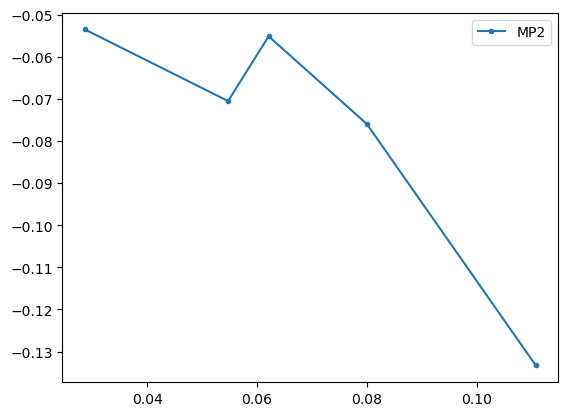

In [42]:
from matplotlib import pyplot as plt
plt.plot(1/gap,mp2_corr_per,'.-',label='MP2')
# plt.plot(1/gap,ccsd_corr_per,'.-',label='CCSD')
plt.legend()
plt.show()

In [11]:
nocc = 7 # 7, 19, 27, 33, 57, 81, 93
my_sys = my_ueg(rs=1.0, nelec=(nocc, nocc))
k_points = my_sys.get_kpts(np.sqrt(2))
n_kpts = k_points.shape[0]
print(f"number of k-points: {n_kpts}")
h0 = my_sys.madelung() / 2
h1 = my_sys.get_h1(k_points)
eri = my_sys.get_eris_hard(k_points)
eri = np.array(eri)

mol = gto.M()
mol.nelectron = system.n_particles
mol.nao = n_kpts
mol.incore_anyway = True
mol.max_memory = 20000
mol.energy_nuc = lambda *args: h0
mol.verbose = 4

dm = np.zeros((n_kpts,n_kpts))
dm[:nocc,:nocc] = np.eye(nocc) * 2.0

mf = scf.RHF(mol)
mf.get_hcore = lambda *args: h1
mf.get_ovlp = lambda *args: np.eye(n_kpts)
# mf.get_jk = get_jk
mf.verbose = 4
mf._eri = eri #ao2mo.restore(8, eri_1, n_kpts)
mf.init_guess = "1e"
mf.max_cycle = -1
escf = mf.kernel(dm0=dm)
print(f"escf: {escf}")
print(f"escf per electron: {escf/system.n_particles}")

mycc = cc.RCCSD(mf)
mycc.max_cycle = 100
# mycc1.conv_tol = 1e-7
mycc.kernel()
print("CCSD energy", mycc.e_tot)
print("CCSD E_corr per electron", mycc.e_corr / system.n_particles)
print("CCSD energy per electron", mycc.e_tot / system.n_particles)

number of k-points: 19


******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = 1e
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = -1
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmp98u4a7tm
max_memory 20000 MB (current use 824 MB)
Set gradient conv threshold to 3.16228e-05
init E= 8.49148146743778
  HOMO = 1.04145818327265  LUMO = 2.32324526529525
SCF not converged.
SCF energy = 8.49148146743778
escf: 8.491481467437776
escf per electron: 0.6065343905312697

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 7, nmo = 19
max_cycle = 100
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 20000 MB (current use 824 MB)
Init t2, MP2 energy = 8.11699308199586  E_corr(MP2) -0.374488385441916
Init E_corr(CCSD) 

In [18]:
nocc = 7 # 7, 19, 27, 33, 57, 81, 93
my_sys = my_ueg(rs=1.0, nelec=(nocc, nocc))
k_points = my_sys.get_kpts(np.sqrt(2))
n_kpts = k_points.shape[0]
print(f"number of k-points: {n_kpts}")
h0 = my_sys.madelung() / 2
h1 = my_sys.get_h1(k_points)
eri = my_sys.get_eris_hard(k_points)
eri = np.array(eri)

number of k-points: 19


In [19]:
from pyscf import ao2mo
eri_2 = ao2mo.restore(4,eri,n_kpts)
print(eri_2.shape)
print(abs(eri_2-eri_2).max())

(190, 190)
0.0
